# Gráficas de Benchmark - DBSCAN

Este notebook carga los archivos de resumen (`serial_summary.csv`, `parallel1_summary.csv`, `parallel2_summary.csv`) y genera las siguientes gráficas:

1. Tiempo de ejecución vs. Número de puntos — comparar versión serial con el mejor resultado de cada versión paralela (entre `parallel1` y `parallel2`).
2. Speedup vs. Número de Hilos — para cada dataset y cada versión paralela.
3. Eficiencia vs. Número de Hilos — para cada dataset y cada versión paralela.

Las librerías usadas son pandas, matplotlib y seaborn.

In [19]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.ticker as mtick

sns.set(style="whitegrid", context="talk")
DATA_DIR = Path('.')

In [20]:
# Leer archivos de resumen provistos en el workspace
serial = pd.read_csv(DATA_DIR / 'serial_summary.csv')
p1 = pd.read_csv(DATA_DIR / 'parallel1_summary.csv')
p2 = pd.read_csv(DATA_DIR / 'parallel2_summary.csv')

# Normalizar nombres de columnas para paralelas (hay pequeñas diferencias en attachments)
p1 = p1.rename(columns=lambda s: s.strip())
p2 = p2.rename(columns=lambda s: s.strip())

serial, p1.head(), p2.head()

(   n_points     mean_ms  mean_cores
 0     20000   779.61559           0
 1     40000  1631.72136           0
 2     80000  3405.78234           0
 3    120000  5317.56493           0
 4    200000  9142.45033           0,
    n_points  threads  mean_ms  cores
 0     20000        1     47.1  19968
 1     20000       10     14.8  19968
 2     20000       20     15.9  19968
 3     20000       40     15.4  19968
 4     40000        1     96.2  39979,
    n_points  threads  mean_ms  mean_cores
 0     20000        1  25.4000       19952
 1     20000       10   7.2000       19952
 2     20000       20   7.6000       19949
 3     20000       40  11.5000       19949
 4     40000        1  57.3999       39962)

In [21]:
# Construir un DataFrame con los mejores tiempos paralelos (mejor entre parallel1 y parallel2)
# Para cada n_points y número de hilos, tomamos mean_ms; luego para la gráfica 1 seleccionamos el mínimo across threads y across p1/p2

# obtener mejor (mínimo) tiempo por n_points en las versiones paralelas (independientemente del número de hilos)
best_p1 = p1.groupby('n_points', as_index=False)['mean_ms'].min().rename(columns={'mean_ms':'mean_ms_p1_best'})
best_p2 = p2.groupby('n_points', as_index=False)['mean_ms'].min().rename(columns={'mean_ms':'mean_ms_p2_best'})

best_par = best_p1.merge(best_p2, on='n_points')
best_par['mean_ms_parallel_best'] = best_par[['mean_ms_p1_best','mean_ms_p2_best']].min(axis=1)

# Unir con serial
# Creamos también dataframes por separado para serial vs p1 y serial vs p2 (útiles para dos gráficas separadas)
df_time = serial.merge(best_par[['n_points','mean_ms_parallel_best']], on='n_points')
df_time = df_time.rename(columns={'mean_ms':'mean_ms_serial'})

df_time_p1 = serial.merge(best_p1, on='n_points').rename(columns={'mean_ms':'mean_ms_serial'})
df_time_p2 = serial.merge(best_p2, on='n_points').rename(columns={'mean_ms':'mean_ms_serial'})

# Preparar datos para speedup/eficiencia: combinar p1 y p2 con columna que identifique la version
p1_v = p1.copy(); p1_v['version'] = 'parallel1'
p2_v = p2.copy(); p2_v['version'] = 'parallel2'
par_all = pd.concat([p1_v, p2_v], ignore_index=True, sort=False)

# Algunas filas pueden tener mean_cores o cores; armonizamos la columna de cores
if 'mean_cores' in par_all.columns:
    par_all = par_all.rename(columns={'mean_cores':'cores'})
if 'cores' not in par_all.columns and 'mean_cores' not in par_all.columns and 'cores' in p1.columns:
    par_all['cores'] = par_all.get('cores')

# Speedup: speedup = T_serial / T_parallel
# Necesitamos T_serial por n_points; unimos
par_all = par_all.merge(serial[['n_points','mean_ms']].rename(columns={'mean_ms':'mean_ms_serial'}), on='n_points')
par_all['speedup'] = par_all['mean_ms_serial'] / par_all['mean_ms']
# Cuidar division por cero y nulos
par_all.loc[~np.isfinite(par_all['speedup']),'speedup'] = np.nan

# Eficiencia: efficiency = speedup / threads (numero de hilos)
# Algunas tablas usan 'threads' o 'thread' - normalizamos
if 'threads' not in par_all.columns and 'thread' in par_all.columns:
    par_all = par_all.rename(columns={'thread':'threads'})

par_all['efficiency'] = par_all['speedup'] / par_all['threads']

# Guardar variables para graficar
df_time, df_time_p1, df_time_p2, par_all.head()

(   n_points  mean_ms_serial  mean_cores  mean_ms_parallel_best
 0     20000       779.61559           0                    7.2
 1     40000      1631.72136           0                   10.9
 2     80000      3405.78234           0                   20.7
 3    120000      5317.56493           0                   30.0
 4    200000      9142.45033           0                   48.6,
    n_points  mean_ms_serial  mean_cores  mean_ms_p1_best
 0     20000       779.61559           0          14.8000
 1     40000      1631.72136           0          27.3000
 2     80000      3405.78234           0          49.8000
 3    120000      5317.56493           0          75.4999
 4    200000      9142.45033           0         129.5000,
    n_points  mean_ms_serial  mean_cores  mean_ms_p2_best
 0     20000       779.61559           0              7.2
 1     40000      1631.72136           0             10.9
 2     80000      3405.78234           0             20.7
 3    120000      5317.56493      

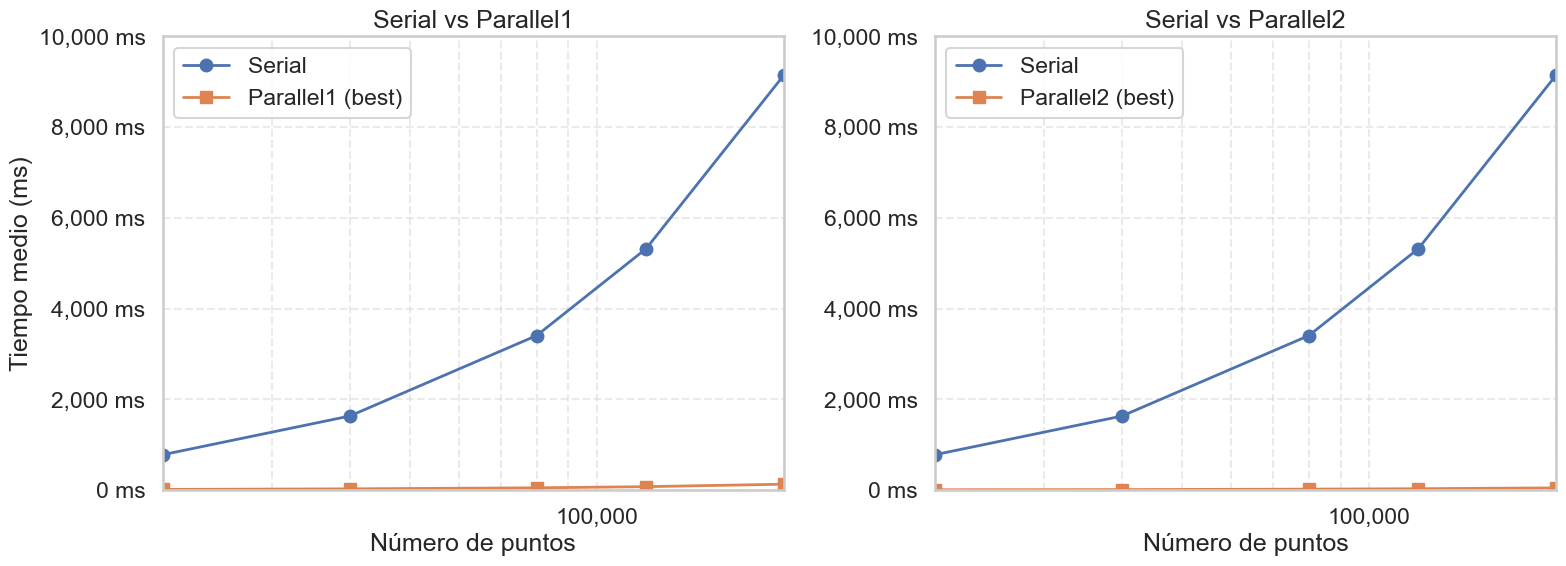

In [23]:
# Gráfica 1: Tiempo de Ejecución vs. Número de Puntos (dos gráficas separadas: parallel1 y parallel2)
fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=False)

# formateador para mostrar ms legibles
def ms_formatter(x, pos):
    try:
        xi = int(round(x))
    except Exception:
        xi = x
    return f"{xi:,} ms"

y_formatter = mtick.FuncFormatter(ms_formatter)

# formateador para eje X con separador de miles
def int_formatter(x, pos):
    try:
        xi = int(round(x))
    except Exception:
        xi = x
    return f"{xi:,}"

x_formatter = mtick.FuncFormatter(int_formatter)

# fijar límites solicitados
XMIN, XMAX = 20000, 200000
YMIN, YMAX = 0, 10000

# parallel1
ax = axes[0]
ax.plot(df_time_p1['n_points'], df_time_p1['mean_ms_serial'], marker='o', label='Serial', linewidth=2)
ax.plot(df_time_p1['n_points'], df_time_p1['mean_ms_p1_best'], marker='s', label='Parallel1 (best)', linewidth=2)
ax.set_xscale('log')
# usar escala lineal en Y para mostrar 0..10000 ms
ax.set_yscale('linear')
ax.set_xlabel('Número de puntos')
ax.set_ylabel('Tiempo medio (ms)')
ax.set_title('Serial vs Parallel1')
ax.legend()
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.set_xlim(XMIN, XMAX)
ax.set_ylim(YMIN, YMAX)
ax.yaxis.set_major_formatter(y_formatter)
ax.xaxis.set_major_formatter(x_formatter)

# parallel2
ax = axes[1]
ax.plot(df_time_p2['n_points'], df_time_p2['mean_ms_serial'], marker='o', label='Serial', linewidth=2)
ax.plot(df_time_p2['n_points'], df_time_p2['mean_ms_p2_best'], marker='s', label='Parallel2 (best)', linewidth=2)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel('Número de puntos')
ax.set_title('Serial vs Parallel2')
ax.legend()
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.set_xlim(XMIN, XMAX)
ax.set_ylim(YMIN, YMAX)
ax.yaxis.set_major_formatter(y_formatter)
ax.xaxis.set_major_formatter(x_formatter)

plt.tight_layout()
plt.show()

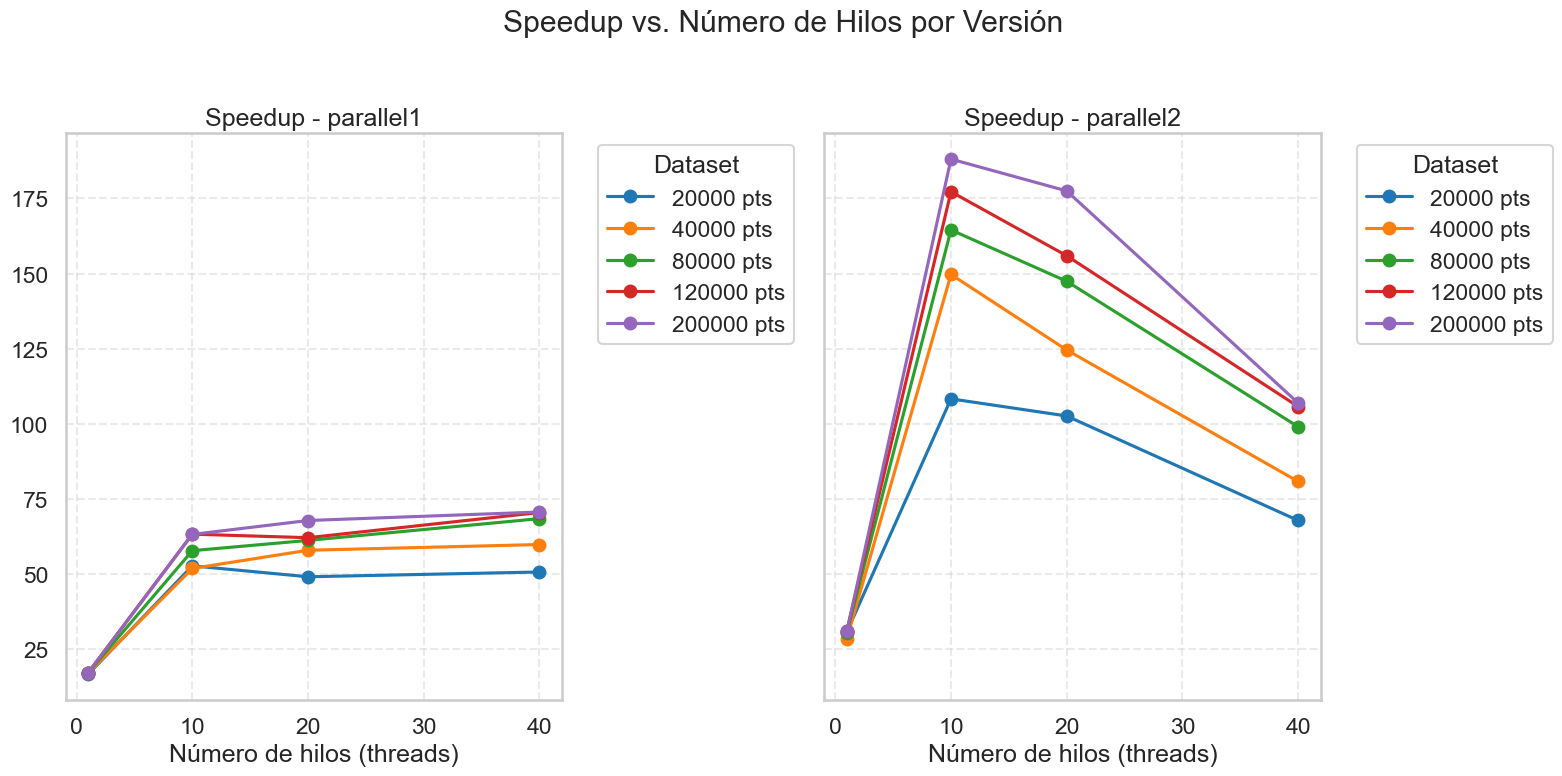

In [24]:
# Gráfica 2: Speedup vs. Número de Hilos (dos subplots separados por versión)
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
# Dibujar una línea por cada n_points dentro de cada versión
palette = sns.color_palette('tab10')
color_map = {n: palette[idx % len(palette)] for idx, n in enumerate(sorted(par_all['n_points'].unique()))}

for ax, version in zip(axes, ['parallel1','parallel2']):
    for n, grp in par_all[par_all['version']==version].groupby('n_points'):
        ax.plot(grp['threads'], grp['speedup'], marker='o', label=f'{n} pts', color=color_map[n])
    ax.set_xlabel('Número de hilos (threads)')
    ax.set_title(f'Speedup - {version}')
    ax.grid(True, ls='--', alpha=0.4)
    ax.legend(title='Dataset', bbox_to_anchor=(1.05,1), loc='upper left')

plt.suptitle('Speedup vs. Número de Hilos por Versión')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

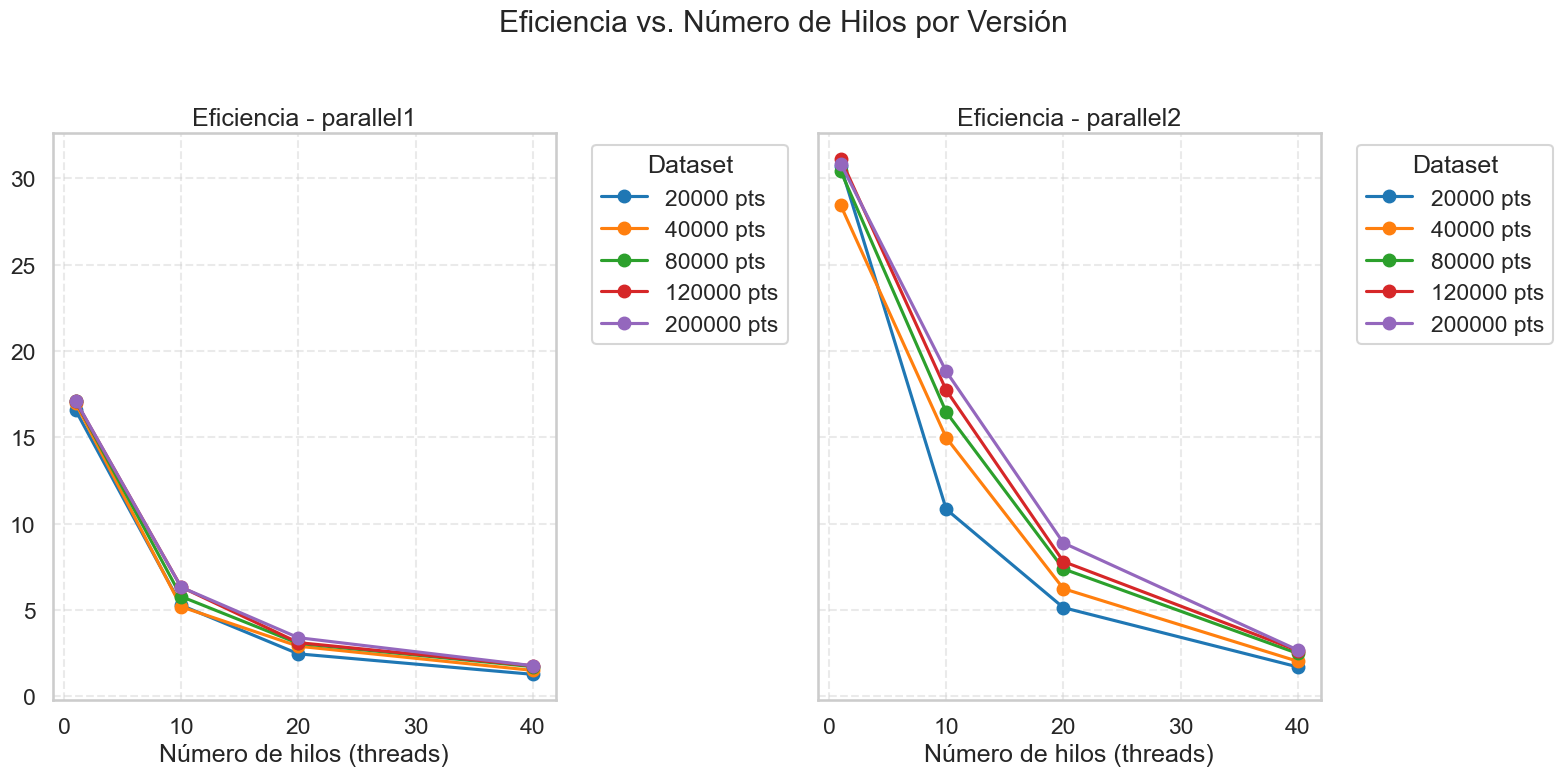

In [25]:
# Gráfica 3: Eficiencia vs. Número de Hilos (dos subplots separados por versión)
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
for ax, version in zip(axes, ['parallel1','parallel2']):
    for n, grp in par_all[par_all['version']==version].groupby('n_points'):
        ax.plot(grp['threads'], grp['efficiency'], marker='o', label=f'{n} pts', color=color_map[n])
    ax.set_xlabel('Número de hilos (threads)')
    ax.set_title(f'Eficiencia - {version}')
    ax.grid(True, ls='--', alpha=0.4)
    ax.legend(title='Dataset', bbox_to_anchor=(1.05,1), loc='upper left')

plt.suptitle('Eficiencia vs. Número de Hilos por Versión')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

Notas:

- El primer conjunto de gráficos ahora contiene dos subplots: uno comparando `Serial` vs `Parallel1 (best)` y otro comparando `Serial` vs `Parallel2 (best)`.
- Para cada subplot calculé límites Y automáticos con un pequeño margen para enfatizar la comparación entre serial y la paralela correspondiente. Ambos usan escalas logarítmicas en X e Y.
- Las gráficas de Speedup y Eficiencia siguen mostrando líneas por combinación (versión paralela, tamaño de dataset). Si se desea, puedo convertir esas gráficas para que también estén separadas por versión (una figura para `parallel1` y otra para `parallel2`) para reducir el ruido en las leyendas.
- Si prefieres que ambos subplots compartan exactamente los mismos límites Y para una comparación directa, dímelo y lo ajusto.